### 文本OCR模型 第1部分：CRNN模型学习

#### OCR CRNN识别的思路
> 把OCR转化成一个“特殊”的分类问题

![](assets/crnn.png)

#### 模型设计

![](assets/crnn_1.png)

>思考题：为什么没有RNN的OCR可以达到非常好的效果？ 

#### OCR的特殊性
> OCR的“特殊性”在于label不定长，所以无法通过普通loss进行损失计算，需要使用CTCLoss

- CTC 的全称是Connectionist Temporal Classification. 这个方法主要是解决神经网络label 和output 不对齐的问题（Alignment problem）
- 非常适合语音识别或者OCR这种应用的。

#### darknet-ocr 的crnn简化版模型结构
- input ==> torch.Size([1, 1, 32, 462])

1. conv_1 
    - Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    - output ==> torch.Size([1, 64, 16, 231])

---

2. conv_2
    - Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    - output ==> torch.Size([1, 128, 8, 116])

---

3. conv_3
    - Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - MaxPool2d(kernel_size=2, **stride=(2, 1)**, padding=0, dilation=1, **ceil_mode=True**)
    - output ==> torch.Size([1, 256, 4, 115])


---

3. conv_4
    - Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - MaxPool2d(kernel_size=2, **stride=(2, 1)**, padding=0, dilation=1, **ceil_mode=True**)

- output ==> torch.Size([1, 512, 2, 114])

---

4. conv_5
    - Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
    - ReLU()
    - output ==> torch.Size([1, 512, **1**, 113])

---

5. conv1x1_FC
    - Conv2d(512, 11316, kernel_size=(1, 1), stride=(1, 1))
    - output ==> torch.Size([1, **11316**, **1**, 113])

---

- output说明: [N, char_nums, h, w]


#### CRNN loss函数设计
criterion = CTCLoss(blank=len(alphabet)-1)
log_preds = torch.nn.functional.log_softmax(preds, dim=2)

cost = criterion(log_preds, label_text, preds_size, label_lenght) / batch_size


#### 问题思考：为什么没有RNN的OCR可以达到非常好的效果？卷积的感受野
##### 什么是感受野
- 参考：https://zhuanlan.zhihu.com/p/39184237
- 感受野（Receptive Field）的定义是卷积神经网络每一层输出的特征图（feature map）上的像素点在输入图片上映射的区域大小。再通俗点的解释是，特征图上的一个点对应输入图上的区域。

![](./assets/crnn_2.jpg)

##### 感受野的计算：
- 两层3*3的卷积核卷积操作之后的感受野是5*5，其中卷积核（filter）的步长（stride）为1、padding为0
- 三层3*3卷积核操作之后的感受野是7*7，其中卷积核的步长为1，padding为0
- 感受野计算时有下面几个知识点需要知道：
    - 最后一层（卷积层或池化层）输出特征图感受野的大小等于卷积核的大小。
    - 第i层卷积层的感受野大小和第i层的卷积核大小和步长有关系，同时也与第（i+1）层感受野大小有关。
    - 计算感受野的大小时忽略了图像边缘的影响，即不考虑padding的大小。
- 关于感受野大小的计算方式是采用从最后一层往下计算的方法，即先计算最深层在前一层上的感受野，然后逐层传递到第一层，使用的公式可以表示如下：

![](./assets/crnn_3.jpg)

##### pytorch-ocr/darknet-ocr中的模型的感受野计算

![](./assets/crnn_3.png)

loading weights:weights/ocr/chinese/ocr_best.pth Done
input ==> torch.Size([1, 1, 32, 462])
Sequential(
  (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky_0): ReLU()
)
==> torch.Size([1, 64, 32, 462])
Sequential(
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
)
==> torch.Size([1, 64, 16, 231])
Sequential(
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky_2): ReLU()
)
==> torch.Size([1, 128, 16, 231])
Sequential(
  (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
)
==> torch.Size([1, 128, 8, 116])
Sequential(
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky_4): ReLU()
)
==> torch.Size([1, 256, 8, 116])
Sequential(
  (conv_5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky_5): ReLU()
)
==> torch.Size([1, 256, 8, 116])
Sequential(
  (maxpool_6): MaxPool2d(kernel_size=2,

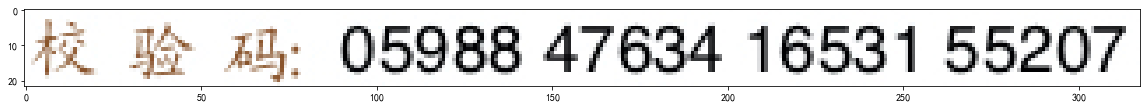

In [1]:
from PIL import Image
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from models.darknet_model import softmax
from models import crnn_model, text_model
import config

charactersPred, _ = config.get_characters()
def decode(pred):
        t = pred.argmax(axis=1)
        prob = [pred[ind, pb] for ind, pb in enumerate(t)]

        length = len(t)
        charList = []
        probList = []
        n = len(charactersPred)
        for i in range(length):
            if t[i] not in [n-1, n-1] and (not (i > 0 and t[i - 1] == t[i])):
                charList.append(charactersPred[t[i]])
                probList.append(prob[i])
        res = {'text': ''.join(charList),
               "prob": float(min(probList)) if len(probList) > 0 else 0}
        return res

net_ocr = crnn_model.CRNN_NET()

### 1. 图片预处理
image = Image.open('test/dd.jpg').convert('L')
scale = image.size[1]*1.0 / 32
w = int(image.size[0] / scale)
image = image.resize((w, 32), Image.BILINEAR)
image = (np.array(image)/255.0-0.5)/0.5
h, w = image.shape
image = torch.tensor(image, dtype=torch.float).view(1, 1, h, w)

### 2. 模型预测
y_pred = image
print('input ==>', image.shape)
for name,m in net_ocr.net.module_list.named_children():
    y_pred = m(y_pred)
    print(m)
    print('==>', y_pred.shape)
#y_pred = net_ocr.net(image)

### 3. 后处理 & decode
out = y_pred[0][:, 0, :].detach().cpu().numpy()
out = out.transpose((1, 0))
out = softmax(out)
out = decode(out)
print(out)

image = Image.open('test/dd.jpg')
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.show()

cpu
loading weights:weights/text/text.pth Done
{'text': '校验码:05988476341653155207', 'prob': 1.0}


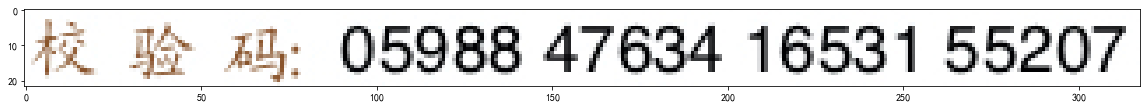

In [3]:
import config
from models import crnn_model, text_model
import sys
import cv2
import time
import matplotlib.pyplot as plt
from PIL import Image

net_text = text_model.TEXT_NET()
img = Image.open('test/dd.jpg')
res = net_ocr.predict(img)
print(res)

plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

#### 扩展学习：其他CRNN模型设计

In [ ]:
# 基于RESNET的CRNN简化模型，目前车牌识别使用的模型

def conv_2x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, (2, 1), 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )


class CRNN_Resnet(nn.Module):
    def __init__(self, imgH, nclass):
        super(CRNN_Resnet, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'
        self.backbone = models.resnet50(pretrained=False)
        # 原restnet50
        #(conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        #(bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        #(relu): ReLU(inplace=True)
        #(maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=(2, 1), padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=(2, 1), padding=1)

        self.stage_out_channels = self.backbone.fc.in_features
        self.conv_last = conv_2x1_bn(
            self.stage_out_channels, self.stage_out_channels)

        self.rnn = nn.Conv2d(self.stage_out_channels, nclass, kernel_size=(
            1, 3), stride=(1, 1), padding=(0, 1), bias=False)

    def forward(self, input):
        # conv features
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        conv = self.backbone.layer4(x)
        conv = self.conv_last(conv)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        # rnn features
        output = self.rnn(conv)

        return output

In [ ]:
# 普通CRNN模型，chinese ocr使用的crnn模型，linear版+lstm版
import torch.nn as nn
import torch
import utils
import dataset
from collections import OrderedDict
from torch.autograd import Variable

class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH=32, nc=1, alphabet=None, nh=256, n_rnn=2, leakyRelu=False, lstmFlag=True):
        
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'
        self.lstmFlag = lstmFlag
        if alphabet == None:
            alphabet = utils.alphabetChinese
            
        nclass = len(alphabet) + 1       
        self.converter = utils.strLabelConverter(alphabet)

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0) 
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x50 , h(32)->h(16),  w(100) -> w(50)
        
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x25 h(16)->h(8), w(50)->w(25)
        
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x26 h(8)->h(4), w(25) -> w(26)
        
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x27 h(4)->h(2), w(26) -> w(27)  
        
        
        convRelu(6, True)  # Conv2d(kernel_size=(2, 2), stride=(1, 1)),  512x1x26 h(2)->h(1), w(27) -> w(26)  
        
        #### tensor shape总结 ######
        # 1. cnn input [N, 1, 32, 100] => output [N, 512, 1, 26]  
        # 2. w = input_w/4 + 1 + 1 - 1 = input_w/4 + 1,   h = input_h/16-1(最后输出必须为1)
        # 3. 默认input [w(100), h(32)] -> [w(26), h(1)]

        self.cnn = cnn
        if self.lstmFlag:
            self.rnn = nn.Sequential(
                BidirectionalLSTM(512, nh, nh),
                BidirectionalLSTM(nh, nh, nclass))
        else:
            self.linear = nn.Linear(nh*2, nclass)

    def forward(self, input):
        # conv features
        conv = self.cnn(input) # input [N, 1, 32, 100] => output [N, 512, 1, 26], T = 26
        
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2) # remove dim(2), h -> [N, 512, 26]  
        conv = conv.permute(2, 0, 1)  # [w, b, c] => [26, N, 512]
        if self.lstmFlag:
            # rnn features
            output = self.rnn(conv) # input [T(26), N, 512] => [w(26), N, nclass(37)]
        
        else:
            T, b, h = conv.size()
            t_rec = conv.contiguous().view(T * b, h)
            output = self.linear(t_rec)  # [T * b, nOut]
            output = output.view(T, b, -1)
        
        return output